In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
counties_info_df = pd.read_csv("./Data/counties.csv")
counties_pop_df = counties_info_df[["fips","population"]]
counties_pop_df.set_index("fips",inplace=True)
counties_pop_df

,population
fips,
2013,3337
2016,5634
2020,288000
2050,18386
2060,836
...,...
56037,42343
56039,23464
56041,20226


In [38]:
from tqdm import tqdm

outliercounties = []

enddate = county_df_list[0].index[-1]
startdate = county_df_list[0].index[2]
for county in tqdm(county_df_list):
    countystartdate = county.index[0]
    if countystartdate > startdate:
        outliercounties.append(county.fips[0])
        previousstartdate = startdate
        startdate = countystartdate
    countyenddate = county.index[-1]
    if countyenddate < enddate:
        enddate = countyenddate
        
print(previousstartdate)
print(startdate)
print(enddate)
print(len(outliercounties))


## Subsetting by dates
print(combinedf.shape)
filtereddf = combinedf.loc['2020-04-04':'2022-01-05']
print(filtereddf.shape)

#FIltering Outlier Coutnies
new_df = filtereddf.loc[~filtereddf['fips'].isin(outliercounties)]
print(new_df.shape)


100%|██████████| 3222/3222 [00:00<00:00, 59175.33it/s]

2020-10-05 00:00:00
2020-12-10 00:00:00
2022-01-05 00:00:00
6


In [ ]:
# def check_inconsistencies(df):
#     fips_value = df['fips'].tolist()[0]
#     global error_message
    
#     subset_df = df[['actuals.newCases','actuals.cases']]
#     previous_cumulative_cases = 0
#     previous_new_cases = 0
#     for index, row in subset_df.iterrows():
#         if previous_cumulative_cases + previous_new_cases > row['actuals.cases']:
#             message = f"Issue at time point: {index} for fips={fips_value}"
#             error_message.append(message)
        
#         previous_cumulative_cases = row['actuals.cases']
#         previous_new_cases = row['actuals.newCases']


In [276]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
global count_cleaned_df
global error_message
error_message= []
from tqdm import tqdm

def fill_missing_days_with_NA(df):
    df.index = pd.DatetimeIndex(df['date'].values)
    new_date_range = pd.date_range(start="2020-04-05", end="2022-01-09", freq="D")
    final_df = df.reindex(new_date_range)
    final_df['date'] = final_df.index

    # final_df = df.asfreq('D')
    # final_df = final_df.loc['2020-04-05':'2022-01-05']
    
    return final_df


def data_preprocessing(df): 
    # columns_to_exclude = ['date', 'riskLevels.overall', 'riskLevels.caseDensity', 'cdcTransmissionLevel']
    columns_to_exclude = ['date']
    new_df = df.loc[:, ~df.columns.isin(columns_to_exclude)]
    
    #Filling missing values using backfill and forwardfill
    new_df.fillna(method="backfill", axis=None, inplace=True)
    new_df.fillna(method="ffill", axis=None, inplace=True)
    
    #Normalization using MinMaxScaler
    cols_to_norm = ['riskLevels.overall', 'riskLevels.caseDensity', 'cdcTransmissionLevel']
    scaler = MinMaxScaler()
    new_df[cols_to_norm] = scaler.fit_transform(new_df[cols_to_norm])
    
    #Copying Date
    new_df['date'] = df.date

    return new_df

def population_feature_engineering(df,fip):
    df["metrics.deathDensity"] = df['actuals.deaths']/counties_pop_df.loc[fip]["population"]
    return df

def seven_day_rolling_average(df): #Rolling only for non-cumulative features
    # df['date'] = pd.DatetimeIndex(df['date'].values)
    rolling_avg_7d_df = df.groupby(pd.Grouper(key='date', axis=0, freq='7D', sort=True)).mean()
    return rolling_avg_7d_df


def merge_cumulative_noncumulative(rolling_7d_df,non_rolling_input_df):
    merged_df = pd.merge(rolling_7d_df,non_rolling_input_df, left_index=True,right_index=True)      
    return merged_df

def clean_fips(df):
    df['fips']=(df['fips']/7).astype(int)
    
original_csv = pd.read_csv("./counties.finalfeatures.timeseries.csv")
original_csv.drop(['actuals.newCases','actuals.newDeaths'],axis=1,inplace=True)
fips_list = list(set(original_csv['fips'].tolist()))
county_df_list = []
# outlier_counties=[]

i=0
for fip in tqdm(fips_list):
    county_df = original_csv[original_csv['fips'] == fip]

    #STEP 1
    county_df = fill_missing_days_with_NA(county_df) 
    #dataframe is set to DateTimeIndex
    
    #STEP 2
    new_county_df = data_preprocessing(county_df)

    #STEP 3
    new_feature_engg_df = population_feature_engineering(new_county_df, fip)
    
    #STEP 4: Merge rolling data frame for non-cumulative features with repsective rows of cumuluative features

    #Split into cumulative and non cumulative:
    cumulative_columns = ['actuals.cases','actuals.deaths', 'metrics.caseDensity', 'metrics.deathDensity', 
                          'metrics.vaccinationsCompletedRatio', 'metrics.vaccinationsInitiatedRatio']
    rolling_input_df = new_feature_engg_df.loc[:, ~new_feature_engg_df.columns.isin(cumulative_columns)]
    non_rolling_input_df = new_feature_engg_df[cumulative_columns]
    
    #STEP 5
    #Pass right data frame to rolling
    rolling_7d_df = seven_day_rolling_average(rolling_input_df)
    
    #STEP 6
    final_df = merge_cumulative_noncumulative(rolling_7d_df,non_rolling_input_df) #Merging both dataframes

    #STEP 7
    county_df_list.append(final_df) #Appending the final dataframe for each county

print(len(county_df_list))

100%|██████████| 3222/3222 [02:48<00:00, 19.10it/s]

3222


## Concatenating list of county dataframes and Removing Outlier

In [277]:
import joblib
joblib.dump(county_df_list, "final_counties_timeseries_list.pkl")
# county_df_list = joblib.load("final_counties_timeseries_list.pkl")

['final_counties_timeseries_list.pkl']

In [33]:
import joblib
county_df_list = joblib.load("/data/BHI_G5/daily_agg_county/daily_agg_counties_timeseries_list.pkl")

county_df_list[0]

,fips,state,county,actuals.cases,actuals.deaths,metrics.caseDensity,metrics.vaccinationsCompletedRatio,metrics.vaccinationsInitiatedRatio,metrics.infectionRate,riskLevels.overall,riskLevels.caseDensity,cdcTransmissionLevel,metrics.testPositivityRatio,date,metrics.deathDensity
2020-04-05,41001.0,OR,Baker County,1.0,0.0,0.0,0.007,0.030,1.00,0.0,0.0,0.333333,0.056,2020-04-05,0.000000
2020-04-06,41001.0,OR,Baker County,1.0,0.0,0.0,0.007,0.030,1.00,0.0,0.0,0.333333,0.056,2020-04-06,0.000000
2020-04-07,41001.0,OR,Baker County,1.0,0.0,0.0,0.007,0.030,1.00,0.0,0.0,0.333333,0.056,2020-04-07,0.000000
2020-04-08,41001.0,OR,Baker County,1.0,0.0,0.0,0.007,0.030,1.00,0.0,0.0,0.333333,0.056,2020-04-08,0.000000
2020-04-09,41001.0,OR,Baker County,1.0,0.0,0.0,0.007,0.030,1.00,0.0,0.0,0.333333,0.056,2020-04-09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,41001.0,OR,Baker County,2351.0,37.0,39.9,0.687,0.853,1.32,0.6,0.6,1.000000,0.170,2022-01-05,0.002295
2022-01-06,41001.0,OR,Baker County,2368.0,37.0,51.4,0.687,0.854,1.34,0.6,0.6,1.000000,0.195,2022-01-06,0.002295
2022-01-07,41001.0,OR,Baker County,2395.0,37.0,71.8,0.687,0.854,1.35,0.6,0.6,1.000000,0.181,2022-01-07,0.002295
2022-01-08,41001.0,OR,Baker County,2395.0,37.0,76.5,0.688,0.855,1.36,1.0,1.0,1.000000,0.181,2022-01-08,0.002295


In [32]:
import pandas as pd
county_df_list[0]['county'][0]

'Baker County'

In [54]:
# plt.plot(date,actual_cases)
# plt.xlabel("Date")
# plt.ylabel("Actual Cases")
# plt.title("Actual Cases")

county_interest = ['Queens County', 'Fulton County', 'Miami-Dade County','Dallas County','San Diego County','Bronx']
states_interest = ['NY', 'GA','FL','TX','CA']

county_plot =[]
for county in county_df_list: 
    if county['county'][0] in county_interest and county['state'][0] in states_interest:
        county_plot.append(county)
        

In [56]:
len(county_plot)
del county_plot[0]

county_plot
#county_plot = county_plot[0]

[             fips state         county  actuals.cases  actuals.deaths  \
 2020-04-05  36081    NY  Queens County        21436.0           813.0   
 2020-04-06  36081    NY  Queens County        23133.0           948.0   
 2020-04-07  36081    NY  Queens County        24840.0          1129.0   
 2020-04-08  36081    NY  Queens County        26248.0          1344.0   
 2020-04-09  36081    NY  Queens County        27752.0          1400.0   
 ...           ...   ...            ...            ...             ...   
 2022-01-05  36081    NY  Queens County       462007.0         10580.0   
 2022-01-06  36081    NY  Queens County       487902.0         10592.0   
 2022-01-07  36081    NY  Queens County       500152.0         10615.0   
 2022-01-08  36081    NY  Queens County       515355.0         10615.0   
 2022-01-09  36081    NY  Queens County       528902.0         10615.0   
 
             metrics.caseDensity  metrics.vaccinationsCompletedRatio  \
 2020-04-05                 67.8      

In [57]:
import joblib
joblib.dump(county_plot, "counties_to_predict.pkl")

['counties_to_predict.pkl']

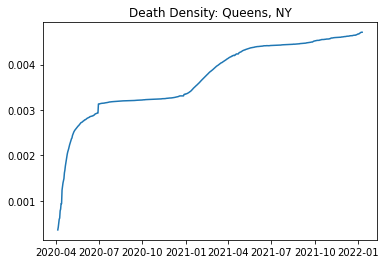

In [86]:
import matplotlib.pyplot as plt

%matplotlib inline

queens = county_plot[0]
q_caseDensity = queens['metrics.deathDensity']
# plt.plot(queens['date'],q_cases)
plt.plot(queens['date'],q_caseDensity)
plt.title('Death Density: Queens, NY')

q_caseDensity = queens['metrics.caseDensity']
q_deathDensity = queens['metrics.deathDensity']
# plt.plot(queens['date'],q_deathDensity)


Text(0.5, 1.0, 'Death Density: Miami,FL')

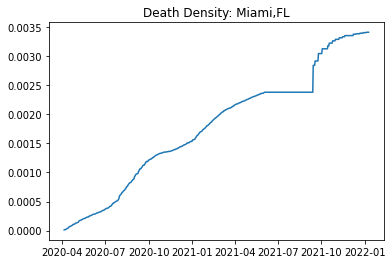

In [87]:
miami = county_plot[1]
m_cases = miami['metrics.deathDensity']
plt.plot(miami['date'],m_cases)
plt.title('Death Density: Miami,FL')

Text(0.5, 1.0, 'Death Density: Fulton,GA')

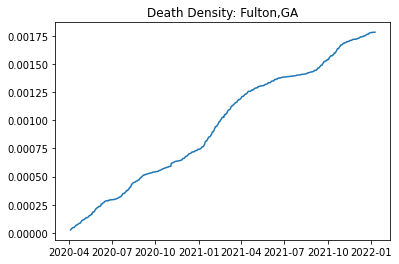

In [88]:
fulton = county_plot[2]
f_cases = fulton['metrics.deathDensity']
plt.plot(fulton['date'],f_cases)
plt.title('Death Density: Fulton,GA')

Text(0.5, 1.0, 'Death Density: San Diego, CA')

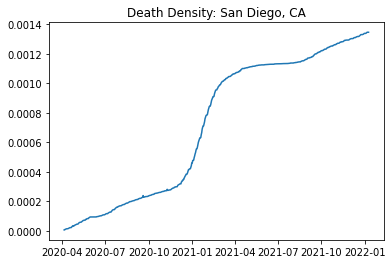

In [89]:
sd = county_plot[3]
sd_cases = sd['metrics.deathDensity']
plt.plot(sd['date'],sd_cases)
plt.title('Death Density: San Diego, CA')

Text(0.5, 1.0, 'Death Density: Dallas, TX')

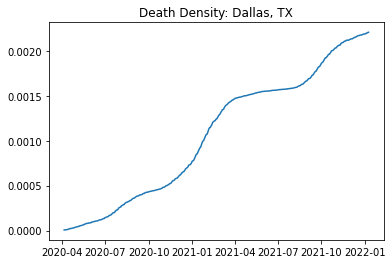

In [90]:
dallas = county_plot[4]
dallas_cases = dallas['metrics.deathDensity']
plt.plot(dallas['date'],dallas_cases)
plt.title('Death Density: Dallas, TX')

In [ ]:
actual_cases = tstates_df["actuals.newCases"]
actual_cases=actual_cases.fillna(actual_cases.mean())


actual_vaccine = tstates_df["actuals.vaccinationsCompleted"]
actual_vaccine=actual_vaccine.fillna(actual_vaccine.mean())


actual_death = tstates_df["actuals.newDeaths"]
actual_death=actual_death.fillna(actual_death.mean())
tstates_df.describe()

tstates_df['date'] = pd.DatetimeIndex(tstates_df['date'])
tstates_df.describe()


In [278]:
## Sanity Check
import pandas as pd
total_rows = 0
for county in county_df_list:
    total_rows += county.shape[0]
print(total_rows)

combinedf = pd.concat(county_df_list)
print(combinedf.shape)

299646
(299646, 12)


In [291]:
# combinedf.loc['2022-01-09']

In [330]:
# statestimeseries_7d_rolling = statestimeseries.rolling(7, center=True).mean()
# start, end = '2020-03', '2022-01'
# fig, ax = plt.subplots()
# ax.plot(statestimeseries.loc[start:end, 'actuals.cases'], linestyle='-', 
#         linewidth=0.5, label='Daily observed cases')
# ax.plot(statestimeseries_week.loc[start:end, 'actuals.cases'], linestyle='-', label = 'Weekly observed actual cases')
# ax.plot(statestimeseries_7d_rolling.loc[start:end, 'actuals.cases'], linestyle='-', label='7d Rolling Average')
# ax.set_ylabel('Actual cases')
# ax.legend()

In [267]:
# # new_cases_daily_total_modified = new_cases_daily_total.T.reset_index()
# new_df_list[0].set_index('date',inplace=True)
# new_df_list[0]
# new_cases_daily_total_modified = new_df_list[0].assign(Weeks = new_df_list[0]['date']).drop(columns = 'date')

# # new_cases_daily_total_modified['Weeks'] =  
# # new_cases_daily_total_modified['Weeks'].astype('datetime64[ns]')

# # new_cases_weekly_total_method_3 = new_cases_daily_total_modified.resample('W-Mon', label='left',closed = 'left', on='Weeks').sum()
# # display(new_cases_weekly_total_method_3.tail(5))

In [ ]:
# first_county_dates = new_df_list[0].date.tolist()
# second_county_dates = new_df_list[2].date.tolist()
# def Diff(li1, li2):
#     return list(set(li1) - set(li2)) + list(set(li2) - set(li1))
# print(Diff(first_county_dates, second_county_dates))

In [42]:
# original_csv.to_csv("Processed.counties.data.csv", index=False)

In [255]:
# county_grouped = final_df_modified.groupby('county')['date', 'state'].apply(list).reset_index()

## Aggregation

## Features to Aggegrate by sum:
- actuals.cases
- actuals.deaths
- metrics.deathDensity
- metrics.caseDensity
- metrics.vaccinationsCompletedRatio
- metrics.vaccinationsInitiatedRatio

## Features to avergae, not sum
- cdcTransmissionLevel
- riskLevels.caseDensity
- riskLevels.overall

In [292]:
combinedf['date']=combinedf.index
agg_sum_df = combinedf.groupby(['date'])['actuals.cases', 'actuals.deaths', 'metrics.deathDensity', 'metrics.caseDensity',
                                            'metrics.vaccinationsCompletedRatio','metrics.vaccinationsInitiatedRatio' ].sum()

agg_means_df = combinedf.groupby(['date'])['cdcTransmissionLevel', 'riskLevels.caseDensity', 'riskLevels.overall'].mean()
agg_df = pd.merge(agg_sum_df,agg_means_df, left_index=True,right_index=True)

In [293]:
agg_sum_df

,actuals.cases,actuals.deaths,metrics.deathDensity,metrics.caseDensity,metrics.vaccinationsCompletedRatio,metrics.vaccinationsInitiatedRatio
date,,,,,,
2020-04-05,331769.0,9285.0,0.031711,9417.1,56.729,177.198
2020-04-12,549809.0,21916.0,0.070352,12146.7,56.729,177.198
2020-04-19,748833.0,38161.0,0.118969,12512.7,56.729,177.198
2020-04-26,959489.0,53092.0,0.174062,16358.1,56.729,177.198
2020-05-03,1152599.0,66659.0,0.223866,17469.2,56.729,177.198
...,...,...,...,...,...,...
2021-12-12,49331346.0,790314.0,9.237984,127866.6,1476.703,1662.023
2021-12-19,50250714.0,799416.0,9.370973,123926.6,1486.710,1673.821
2021-12-26,51630211.0,809463.0,9.521987,140811.6,1493.372,1683.062


In [294]:
agg_means_df

,cdcTransmissionLevel,riskLevels.caseDensity,riskLevels.overall
date,,,
2020-04-05,0.458241,0.107910,0.205765
2020-04-12,0.456737,0.111223,0.200008
2020-04-19,0.426004,0.112013,0.186846
2020-04-26,0.415418,0.122543,0.187413
2020-05-03,0.384666,0.130409,0.183830
...,...,...,...
2021-12-12,0.890348,0.513403,0.530895
2021-12-19,0.932994,0.534773,0.548895
2021-12-26,0.973623,0.626574,0.638556


In [295]:
agg_df

,actuals.cases,actuals.deaths,metrics.deathDensity,metrics.caseDensity,metrics.vaccinationsCompletedRatio,metrics.vaccinationsInitiatedRatio,cdcTransmissionLevel,riskLevels.caseDensity,riskLevels.overall
date,,,,,,,,,
2020-04-05,331769.0,9285.0,0.031711,9417.1,56.729,177.198,0.458241,0.107910,0.205765
2020-04-12,549809.0,21916.0,0.070352,12146.7,56.729,177.198,0.456737,0.111223,0.200008
2020-04-19,748833.0,38161.0,0.118969,12512.7,56.729,177.198,0.426004,0.112013,0.186846
2020-04-26,959489.0,53092.0,0.174062,16358.1,56.729,177.198,0.415418,0.122543,0.187413
2020-05-03,1152599.0,66659.0,0.223866,17469.2,56.729,177.198,0.384666,0.130409,0.183830
...,...,...,...,...,...,...,...,...,...
2021-12-12,49331346.0,790314.0,9.237984,127866.6,1476.703,1662.023,0.890348,0.513403,0.530895
2021-12-19,50250714.0,799416.0,9.370973,123926.6,1486.710,1673.821,0.932994,0.534773,0.548895
2021-12-26,51630211.0,809463.0,9.521987,140811.6,1493.372,1683.062,0.973623,0.626574,0.638556


In [297]:
agg_df.to_csv("county_aggregated_timeseries.csv")